# USING DATA COLLECTED AT MURITALA MUHAMMED INT'L AIRPORT WEATHER STATION TO PREDICT FUTURE WEATHER TEMPERATURE.

THE DATASET USED IN THIS PROJECT WAS COLLECTED AT MMIA WEATHER STATION BY NATIONAL CENTERS FOR ENVIROMENTAL INFORMATION-NATIONAL OCEANIC AND ATMOSPHERIC ADMINISTRATION AND IT IS AVAILABLE ON REQUEST ON THEIR WEBSITE:
https://www.ncdc.noaa.gov/cdo-web

#####  THIS PROJECT WAS EXECUTED BY 4 GROUP MEMBERS WHOSE NAMES ARE; 
ILOH FRANSISCA ONYINYECHUKWU
QUDUS OLAYEMI SHITTU
SALIMON ABUBAKAR OWOLABI
GIDEON EKWERE

In [1]:
#STEPS FOLLOWED

#1. IMPORT LIBRARIES
#2. IMPORT DATASET 
#3. EXPLORE DATA AND FILL IN MISSING VALUES USING FORWARDFILL AND BACKWARDFILL
#4. PERFORMING EXPLORATORY DATA ANALYSIS ON THE DATASET
#5. CHOOSING A TARGET DATA
#6. APPLYING REGRESSION MODELS FOR PREDICTIONS
#7. EVALUATE THE MODEL PERFORMANCE WITH THREE DIFFERENT METRICS NAMELY; MEAN ABSOLUTE ERROR, R2 SCORE & MEAN SQUARED ERROR.
#8. PERFORMING HYPERPARAMETER TUNNING TO IMPROVE MODEL PERFORMANCE
#9. PLOTING A GRAPH TO VISUALIZE THE BEST PERFORMING MODEL

## IMPORTING DATASET ##

In [2]:
# IMPORTING ALL THE LIBRARIES #
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

C:\Users\pc\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# IMPORTING THE DATASET AND USING THE DATE COLUMN AS THE INDEXT COLUMN BECAUSE IT HAVE A UNIQUE VALUE 
weather = pd.read_csv("Nigeria Airport Record.csv", index_col="DATE")

In [4]:
# VIEWING THE DATASET 
weather

,STATION,NAME,PRCP,TAVG,TMAX,TMIN
DATE,,,,,,
1999-01-03,NIM00065201,"MURTALA MUHAMMED, NI",NaN,85,92.0,77.0
1999-01-04,NIM00065201,"MURTALA MUHAMMED, NI",NaN,83,90.0,78.0
1999-01-05,NIM00065201,"MURTALA MUHAMMED, NI",NaN,80,88.0,78.0
1999-01-06,NIM00065201,"MURTALA MUHAMMED, NI",NaN,83,NaN,77.0
1999-01-07,NIM00065201,"MURTALA MUHAMMED, NI",NaN,83,91.0,72.0
...,...,...,...,...,...,...
2024-01-15,NIM00065201,"MURTALA MUHAMMED, NI",NaN,85,96.0,78.0
2024-01-16,NIM00065201,"MURTALA MUHAMMED, NI",NaN,85,NaN,78.0
2024-01-17,NIM00065201,"MURTALA MUHAMMED, NI",NaN,87,NaN,NaN


In [5]:
# CHECKING FOR NULL VALUES 
null_pct = weather.apply(pd.isnull).sum()/weather.shape[0]
null_pct

STATION    0.000000
NAME       0.000000
PRCP       0.879607
TAVG       0.000000
TMAX       0.391073
TMIN       0.510374
dtype: float64

In [6]:
# CONVERTING COLUMNS TO LOWER CASE 
weather.columns = weather.columns.str.lower()

In [7]:
# FORWARD FILLING OF NULL VALUES 
weather = weather.ffill()

In [8]:
# CHECKING IF THERE ARE STILL NULL VALUES AFTER FORWARD FILLING 
weather.apply(pd.isnull).sum()

station      0
name         0
prcp       222
tavg         0
tmax         0
tmin         0
dtype: int64

In [9]:
# BACKWARD FILLING OF NULL VALUES 
weather = weather.bfill()

In [10]:
# CHECKING IF THERE ARE STILL NULL VALUES AFTER BACKWARD FILLING 
weather.apply(pd.isnull).sum()

station    0
name       0
prcp       0
tavg       0
tmax       0
tmin       0
dtype: int64

In [11]:
# CHECKING FOR THE DATA TYPE OF EACH COLUMN OF THE DATASET 
weather.dtypes

station     object
name        object
prcp       float64
tavg         int64
tmax       float64
tmin       float64
dtype: object

In [12]:
# CONVERTING THE DATE COLUMN INTO DATETIME FOR EASY ANALYSIS  
weather.index = pd.to_datetime(weather.index)

In [13]:
# Counting occurrences of each unique year in the extracted series and sorting the series by index (years) in ascending order
weather.index.year.value_counts().sort_index()

DATE
1999    295
2000    107
2001    261
2002    186
2003    118
2004    185
2005    219
2006    281
2007    259
2008    236
2009    359
2010    358
2011    365
2012    355
2013    334
2014    281
2015    299
2016    366
2017    291
2018    358
2019    362
2020    360
2021    355
2022    361
2023    356
2024     19
Name: count, dtype: int64

## EXPLORATORY DATA ANALYSIS ##

<Axes: xlabel='DATE'>

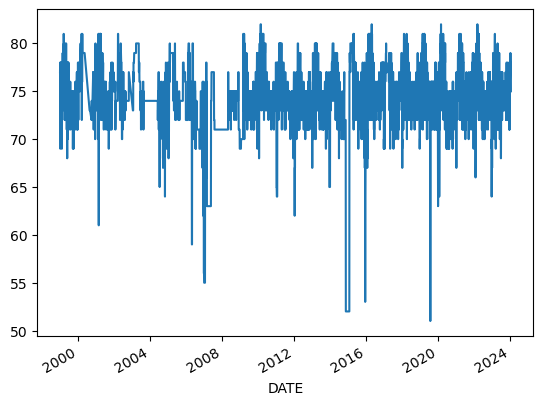

In [14]:
# Generating a line plot of the minimum temperatur
weather["tmin"].plot()

<Axes: xlabel='DATE'>

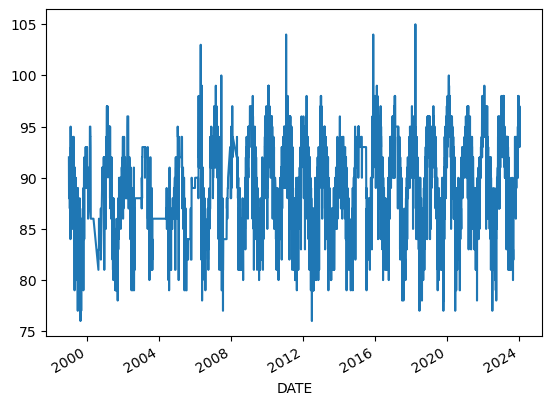

In [15]:
# Generating a line plot of the maximum temperatur
weather["tmax"].plot()

<Axes: xlabel='DATE'>

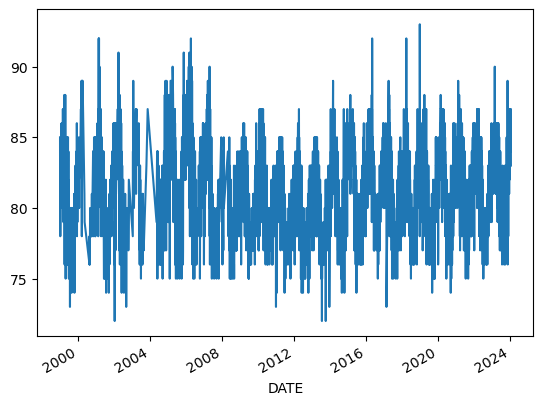

In [16]:
# Generating a line plot of the average temperatur
weather["tavg"].plot()

<Axes: xlabel='DATE'>

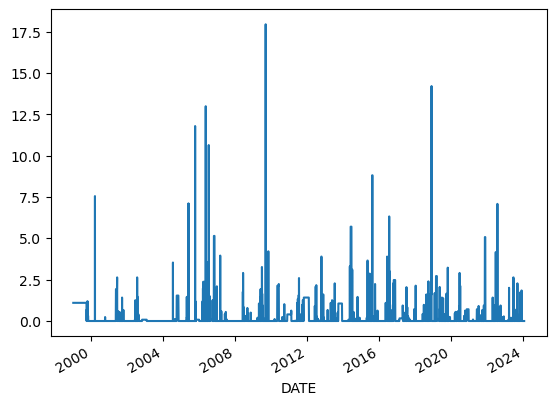

In [17]:
# Generating a line plot of the precipitation
weather["prcp"].plot()

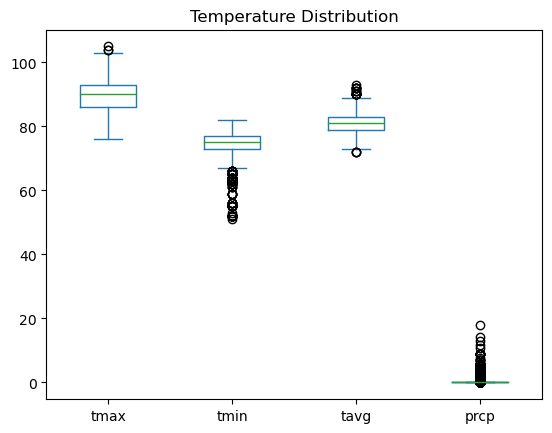

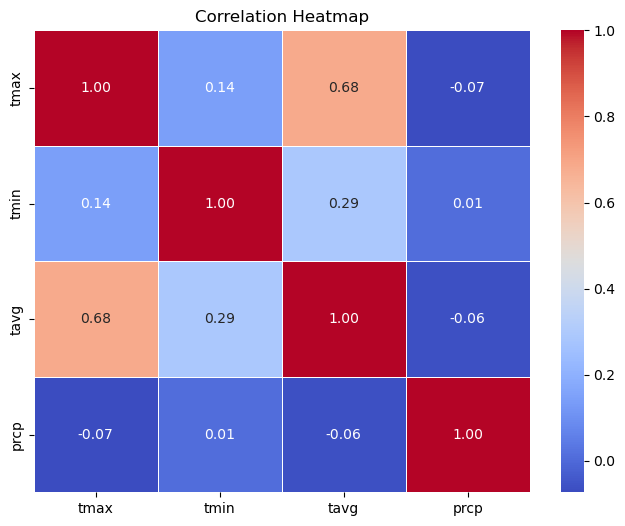

In [18]:
# Extracting the specified columns
selected_columns = ['tmax', 'tmin', 'tavg', 'prcp']
selected_data = weather[selected_columns]

# Plotting a box plot 
selected_data.plot(kind='box', title='Temperature Distribution')
plt.show()

# Creating a heatmap for the correlation matrix
correlation_matrix = selected_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


## DATA PREPROCESSING ##

In [19]:
# Creating a target column for time-series forecasting
# The 'target' column is derived by shifting the 'tmax' column one time step into the future.
# Each row in the 'target' column corresponds to the maximum temperature ('tmax') of the following time step.
# This prepares the dataset for a time-series forecasting task where the goal is to predict future 'tmax' values.
weather["target"] = weather.shift(-1)["tmax"]

In [20]:
weather

,station,name,prcp,tavg,tmax,tmin,target
DATE,,,,,,,
1999-01-03,NIM00065201,"MURTALA MUHAMMED, NI",1.1,85,92.0,77.0,90.0
1999-01-04,NIM00065201,"MURTALA MUHAMMED, NI",1.1,83,90.0,78.0,88.0
1999-01-05,NIM00065201,"MURTALA MUHAMMED, NI",1.1,80,88.0,78.0,88.0
1999-01-06,NIM00065201,"MURTALA MUHAMMED, NI",1.1,83,88.0,77.0,91.0
1999-01-07,NIM00065201,"MURTALA MUHAMMED, NI",1.1,83,91.0,72.0,89.0
...,...,...,...,...,...,...,...
2024-01-15,NIM00065201,"MURTALA MUHAMMED, NI",0.0,85,96.0,78.0,96.0
2024-01-16,NIM00065201,"MURTALA MUHAMMED, NI",0.0,85,96.0,78.0,96.0
2024-01-17,NIM00065201,"MURTALA MUHAMMED, NI",0.0,87,96.0,78.0,96.0


In [21]:
# Forward filling null value
weather = weather.ffill()

#### The code calculates rolling averages and percentage changes for specified columns ("tmax", "tmin", "prcp") with different rolling window sizes (3 and 14) and appends the results to the 'weather' DataFrame. The pct_diff_safe function is used to handle cases where the old value is zero to prevent division by zero errors

In [22]:
# Iterates over different rolling horizons (window sizes) and columns, updating the 'weather' DataFrame with rolling statistics.
# For each rolling horizon and column ('tmax', 'tmin', 'prcp'):
# Computes and adds a new column for rolling averages labeled as 'rolling_horizon_col'.
# Calculates the percentage change safely between the rolling average and the original column values, adding a new column labeled as 'rolling_horizon_col_pct'.
# Updates the 'weather' DataFrame with the newly computed columns.

def pct_diff_safe(old, new):
    # Checking if old value is zero to avoid division by zero
    return (new - old) / old if old != 0 else 0.0

def compute_rolling(weather, horizon, col):
    label = f"rolling_{horizon}_{col}"
    weather[label] = weather[col].rolling(horizon).mean()
    
    # Calculating percentage change safely
    weather[f"{label}_pct"] = weather.apply(lambda row: pct_diff_safe(row[label], row[col]), axis=1)
    
    return weather

rolling_horizons = [3, 14]
for horizon in rolling_horizons:
    for col in ["tmax", "tmin", "prcp"]:
        weather = compute_rolling(weather, horizon, col)

#### This code is calculating two types of expanding averages for each of the columns "tmax," "tmin," and "prcp" based on the year and month (year_month_avg) and year and day of the year (year_day_avg)

In [23]:
# Computing Year-Month and Year-Day Expanding Averages:
# For each weather variable ('tmax', 'tmin', 'prcp'), the code calculates two types of expanding averages:
# 1. Year-Month-wise Expanding Average:
#    - Groups the data by year and month, computes the expanding average for each group.
#    - Creates new columns labeled as 'year_month_avg_col' to store the results.
# 2. Year-Day-wise Expanding Average:
#    - Groups the data by year and day of the year, computes the expanding average for each group.
#    - Creates new columns labeled as 'year_day_avg_col' to store the results.

for col in ["tmax", "tmin", "prcp"]:
    weather[f"year_month_avg_{col}"] = weather[col].groupby([weather.index.year, weather.index.month], group_keys=False).expanding().mean().reset_index(drop=True)
    weather[f"year_day_avg_{col}"] = weather[col].groupby([weather.index.year, weather.index.day_of_year], group_keys=False).expanding().mean().reset_index(drop=True)

In [24]:
weather

,station,name,prcp,tavg,tmax,tmin,target,rolling_3_tmax,rolling_3_tmax_pct,rolling_3_tmin,...,rolling_14_tmin,rolling_14_tmin_pct,rolling_14_prcp,rolling_14_prcp_pct,year_month_avg_tmax,year_day_avg_tmax,year_month_avg_tmin,year_day_avg_tmin,year_month_avg_prcp,year_day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
1999-01-03,NIM00065201,"MURTALA MUHAMMED, NI",1.1,85,92.0,77.0,90.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-04,NIM00065201,"MURTALA MUHAMMED, NI",1.1,83,90.0,78.0,88.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-05,NIM00065201,"MURTALA MUHAMMED, NI",1.1,80,88.0,78.0,88.0,90.000000,-0.022222,77.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-06,NIM00065201,"MURTALA MUHAMMED, NI",1.1,83,88.0,77.0,91.0,88.666667,-0.007519,77.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-07,NIM00065201,"MURTALA MUHAMMED, NI",1.1,83,91.0,72.0,89.0,89.000000,0.022472,75.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-15,NIM00065201,"MURTALA MUHAMMED, NI",0.0,85,96.0,78.0,96.0,95.000000,0.010526,78.000000,...,77.642857,0.004600,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-16,NIM00065201,"MURTALA MUHAMMED, NI",0.0,85,96.0,78.0,96.0,95.000000,0.010526,78.000000,...,77.714286,0.003676,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-17,NIM00065201,"MURTALA MUHAMMED, NI",0.0,87,96.0,78.0,96.0,96.000000,0.000000,78.000000,...,77.785714,0.002755,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Trimming the first 2 rows from the 'weather' DataFrame
# This operation removes the initial rows, possibly containing NaN values or irrelevant data.
weather = weather.iloc[2:,:]
weather = weather.fillna(0)

In [26]:
weather

,station,name,prcp,tavg,tmax,tmin,target,rolling_3_tmax,rolling_3_tmax_pct,rolling_3_tmin,...,rolling_14_tmin,rolling_14_tmin_pct,rolling_14_prcp,rolling_14_prcp_pct,year_month_avg_tmax,year_day_avg_tmax,year_month_avg_tmin,year_day_avg_tmin,year_month_avg_prcp,year_day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
1999-01-05,NIM00065201,"MURTALA MUHAMMED, NI",1.1,80,88.0,78.0,88.0,90.000000,-0.022222,77.666667,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-01-06,NIM00065201,"MURTALA MUHAMMED, NI",1.1,83,88.0,77.0,91.0,88.666667,-0.007519,77.666667,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-01-07,NIM00065201,"MURTALA MUHAMMED, NI",1.1,83,91.0,72.0,89.0,89.000000,0.022472,75.666667,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-01-08,NIM00065201,"MURTALA MUHAMMED, NI",1.1,80,89.0,72.0,89.0,89.333333,-0.003731,73.666667,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-01-09,NIM00065201,"MURTALA MUHAMMED, NI",1.1,78,89.0,69.0,88.0,89.666667,-0.007435,71.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-15,NIM00065201,"MURTALA MUHAMMED, NI",0.0,85,96.0,78.0,96.0,95.000000,0.010526,78.000000,...,77.642857,0.004600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-16,NIM00065201,"MURTALA MUHAMMED, NI",0.0,85,96.0,78.0,96.0,95.000000,0.010526,78.000000,...,77.714286,0.003676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-17,NIM00065201,"MURTALA MUHAMMED, NI",0.0,87,96.0,78.0,96.0,96.000000,0.000000,78.000000,...,77.785714,0.002755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## MODEL BUILDING AND EVALUATION ##

### RIDGE REGRESSION ALGORITHM

Ridge Regression is a linear regression technique that incorporates regularization to improve the performance and generalization of the model, particularly in the presence of multicollinearity (high correlation among predictor variables). Also known as Tikhonov regularization or L2 regularization, Ridge Regression adds a penalty term to the linear regression objective function.

Key Aspects:

Objective Function:

Ridge Regression minimizes the sum of squared errors between predicted and actual outcomes, similar to standard linear regression.
Additionally, it introduces a regularization term, proportional to the squared magnitude of the coefficients (L2 norm), to prevent overfitting.
Regularization Parameter (Alpha):

The regularization strength is controlled by a hyperparameter, often denoted as alpha.
A higher alpha increases the regularization effect, leading to smaller and more robust coefficients.
Coefficient Shrinkage:

Ridge Regression penalizes large coefficients, discouraging the model from relying too heavily on any single predictor variable.
This helps address multicollinearity issues and improves the stability of the model.
Advantages:

Effective in handling multicollinearity by stabilizing coefficient estimates.
Suitable for cases where the number of predictors is greater than the number of observations.
Implementation:

Ridge Regression is implemented by modifying the linear regression optimization problem with the additional regularization term.
Optimization techniques such as gradient descent or closed-form solutions like the Ridge Regression equation can be used.
Bias-Variance Tradeoff:

Ridge Regression introduces a bias term in the estimates but reduces the variance, offering a tradeoff that can lead to improved model generalization.
Use Cases:

Commonly applied in scenarios where predictor variables are highly correlated.
Suitable for situations with a potentially large number of features.
In summary, Ridge Regression is a valuable tool in linear regression when dealing with multicollinearity and overfitting. By introducing a regularization term, it strikes a balance between fitting the data well and preventing overly complex models, making it a robust choice in various regression scenarios.

In [27]:
# Ridge Regression Model Initialization:
# Creating a Ridge Regression model with a regularization strength (alpha) set to 0.01.
# Ridge Regression is a linear regression technique with L2 regularization, and the alpha parameter controls the strength of regularization.
# A smaller alpha value allows for less regularization, while a larger alpha value increases regularization.

rr = Ridge(alpha=0.01)

In [28]:
# Selecting Predictors for Modeling:
# Extracting predictor variables for modeling by excluding columns such as "target," "name," and "station."
# The code uses the columns attribute of the 'weather' DataFrame to identify all columns
# except those specified in the exclusion list ["target", "name", "station"].

predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]

#### This code defines a function named backtest that performs a backtesting procedure for a given predictive model on a time series dataset, such as weather data. ####

In [29]:
# Time Series Backtesting Function:
# Performing a backtesting procedure for a predictive model on a time series dataset.
def backtest(weather, model, predictors, start=1462, step=90):
    # Initializing an empty list to store predictions for each backtesting iteration
    all_predictions = []
    
    # Iterating over the time series data with specified start index and step size
    for i in range(start, weather.shape[0], step):
        # Split the data into training and testing sets
        train = weather.iloc[:i, :]
        test = weather.iloc[i:(i+step), :]
        
        # Fitting the model on the training data
        model.fit(train[predictors], train["target"])
        
        # Making predictions on the testing data
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        
        # Combining actual and predicted values into a DataFrame
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        
        # Calculating the absolute difference between predicted and actual values
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        
        # Appending the results for this iteration to the list
        all_predictions.append(combined)
    
    # Concatenating all the results into a single DataFrame and return it
    return pd.concat(all_predictions)

In [30]:
# Generate Predictions using Backtesting:
# Using the 'backtest' function to generate predictions for the 'weather' dataset
# based on a Ridge Regression model ('rr') and a set of predictor variables ('predictors').
# The resulting 'predictions' DataFrame contains actual, predicted, and difference values
# for each backtesting iteration, facilitating the evaluation of the model's performance.

predictions = backtest(weather, rr, predictors)

In [31]:
# Calculate Mean Absolute Error (MAE):
# Using the mean_absolute_error function from scikit-learn to quantify the average absolute difference
# between the actual and predicted values in the 'predictions' DataFrame.
# MAE provides a measure of the model's average prediction error, with lower values indicating better performance.
mean_absolute_error(predictions["actual"], predictions["prediction"])

1.495416811217836

In [32]:
# Sort Predictions by Absolute Difference:
# Sorting the 'predictions' DataFrame in descending order based on the absolute difference ('diff') column.
# This allows for a quick examination of the predictions with the largest errors.
# Rows with higher absolute differences indicate instances where the model's predictions deviate more from the actual values.
predictions.sort_values("diff", ascending=False)

,actual,prediction,diff
DATE,,,
2018-04-01,105.0,92.097129,12.902871
2011-04-03,82.0,94.846371,12.846371
2015-11-28,104.0,91.356724,12.643276
2007-06-21,100.0,87.623747,12.376253
2014-11-27,82.0,94.329387,12.329387
...,...,...,...
2006-12-21,91.0,91.001061,0.001061
2023-10-05,88.0,87.999106,0.000894
2022-02-03,95.0,95.000379,0.000379


In [33]:
#CHECKING THE r2 SCORE FOR CORRELATION, TO EVALUATE OUR MODEL.
r2 = r2_score(predictions["actual"], predictions["prediction"])
r2 #(The result of 0.7 shows that we have a pretty high correlation).

0.7518993248703836

### GRADIENT BOOSTING REGRESSOR ALGORITHM

Gradient Boosting Regressor is an ensemble learning algorithm that builds a predictive model in a stepwise manner, combining the predictions of multiple weak learners (typically decision trees). It belongs to the family of boosting algorithms, and its key characteristic is the sequential addition of models to correct errors made by the previous ones.

Key Aspects:

Boosting Concept:

Gradient Boosting builds an ensemble of weak learners, where each learner corrects the errors of the preceding one.
It combines multiple weak models to create a strong predictive model.
Sequential Training:

Models are added sequentially, with each new model focusing on the residuals (errors) of the combined ensemble so far.
The process continues until a predefined number of models is reached or performance reaches a satisfactory level.
Gradient Descent Optimization:

The algorithm minimizes a loss function by using gradient descent optimization.
At each iteration, it calculates the gradient of the loss with respect to the predicted values and adjusts the model accordingly.
Weak Learners (Decision Trees):

The default weak learners are often shallow decision trees, called decision stumps, which are weak but computationally efficient.
Hyperparameters:

Key hyperparameters include the learning rate (controls the contribution of each weak learner) and the depth of the individual trees.
Adjusting hyperparameters is crucial for balancing model complexity and avoiding overfitting.
Robustness:

Gradient Boosting is robust to outliers and can capture complex relationships in the data.
Use Cases:

Commonly used in regression tasks where the goal is to predict continuous numerical values.
Effective for structured data with a moderate to large number of features.
In summary, Gradient Boosting Regressor is a powerful algorithm for building predictive models through the sequential addition of weak learners. It is known for its high predictive accuracy and flexibility, making it a popular choice in various regression scenarios.

In [34]:
# Creating a Gradient Boosting Regressor:
# Initializing a Gradient Boosting Regressor with specified hyperparameters.
# Adjusting hyperparameters like the number of estimators, maximum depth, and learning rate based on the modeling requirements.
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)  

# Example Backtesting with Gradient Boosting Regressor:
# Using the 'backtest' function to evaluate the performance of the Gradient Boosting Regressor ('gb_model')
# on the 'weather' dataset with a set of predictor variables ('predictors').
# The backtesting starts from the specified index (start=1462) and progresses in intervals (step=90).
result_gb = backtest(weather, gb_model, predictors, start=1462, step=90)

In [35]:
# Calculating and Print R-squared (R2) Score:
# Using the r2_score function from scikit-learn to compute the R-squared (R2) score,
# which measures the proportion of variance in the target variable explained by the model.
# The R2 score ranges from 0 to 1, where 1 indicates a perfect fit.

r2 = r2_score(result_gb["actual"], result_gb["prediction"])

# Printing the R-squared (R2) score
print(f"R-squared (R2) Score: {r2}")

R-squared (R2) Score: 0.5344186887786886


In [36]:
# Calculating and Print Mean Squared Error (MSE) and Mean Absolute Error (MAE):
# Using the mean_squared_error and mean_absolute_error functions from scikit-learn to compute
# the Mean Squared Error (MSE) and Mean Absolute Error (MAE), respectively, for model evaluation.
mse = mean_squared_error(result_gb["actual"], result_gb["prediction"])
mae = mean_absolute_error(result_gb["actual"], result_gb["prediction"])

# Printing the Mean Squared Error (MSE) and Mean Absolute Error (MAE) values
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 8.82343729299533
Mean Absolute Error (MAE): 2.0350564466098273


### SUPPORT VECTOR REGRESSOR ALGORITHM

Support Vector Regressor (SVR) is a machine learning algorithm used for regression tasks. It is a variant of Support Vector Machines (SVMs) designed for predicting continuous numeric values. SVR excels in capturing complex relationships and is particularly useful in scenarios with non-linear data patterns.

Key Aspects:

Regression with Support Vectors:

SVR extends the concepts of SVMs from classification to regression.
Instead of classifying data points into categories, SVR predicts a continuous output.
Kernel Trick:

SVR utilizes the kernel trick to transform input data into a higher-dimensional space, making it possible to capture non-linear relationships.
Common kernels include linear, polynomial, and radial basis function (RBF).
Support Vectors:

Support vectors are data points that have a significant influence on determining the optimal hyperplane for regression.
SVR focuses on minimizing errors while ensuring a margin of tolerance around the predicted values.
Epsilon-Sensitive Loss Function:

SVR introduces an epsilon-sensitive loss function that allows for a tolerance margin (epsilon) within which errors are acceptable.
Hyperparameters:

Key hyperparameters include the choice of kernel, regularization parameter (C), and kernel-specific parameters.
Proper tuning of hyperparameters is essential for achieving optimal performance.
Scalability:

SVR may require careful preprocessing of data and tuning of hyperparameters, especially when dealing with large datasets.
Scaling of features is often necessary for optimal performance.
Use Cases:

Suitable for regression tasks where capturing complex, non-linear relationships is crucial.
Effective in scenarios with moderate to high-dimensional feature spaces.
In summary, Support Vector Regressor is a powerful algorithm for regression tasks, leveraging the principles of SVMs to predict continuous numeric values. Its ability to handle non-linear patterns and capture complex relationships makes it a valuable tool in various regression scenarios.

In [ ]:
# Creating a Support Vector Machine (SVM) Regressor:
# Initializing a Support Vector Machine Regressor with a linear kernel and C parameter set to 1.0.
# Adjusting the kernel type (linear, polynomial, radial basis function, etc.) and the C parameter based on modeling requirements.
svm_model = SVR(kernel='linear', C=1.0)  # Adjust kernel and C parameter as needed

# Example usage with the Support Vector Machine Regressor
result_svm = backtest(weather, svm_model, predictors, start=1462, step=90)


In [ ]:
# Calculating R-squared, MSE, and MAE for SVM predictions
r2_svm = r2_score(result_svm["actual"], result_svm["prediction"])
mse_svm = mean_squared_error(result_svm["actual"], result_svm["prediction"])
mae_svm = mean_absolute_error(result_svm["actual"], result_svm["prediction"])

# Printing the Mean Squared Error (MSE) and Mean Absolute Error (MAE) values
print(f"SVM - R-squared (R2) Score: {r2_svm}")
print(f"SVM - Mean Squared Error (MSE): {mse_svm}")
print(f"SVM - Mean Absolute Error (MAE): {mae_svm}")

### XGBOOST REGRESSOR ALGORITHM

XGBoost Regressor is an advanced implementation of the gradient boosting algorithm designed for regression tasks. Known for its efficiency, speed, and high performance, XGBoost stands for eXtreme Gradient Boosting. It is widely used in data science competitions and real-world applications due to its robustness and ability to handle complex relationships in data.

Key Aspects:

Gradient Boosting Framework:

XGBoost is built on the gradient boosting framework, where weak learners (typically decision trees) are combined sequentially to improve model accuracy.
Regularization Techniques:

XGBoost incorporates L1 (Lasso) and L2 (Ridge) regularization techniques to control model complexity and prevent overfitting.
Parallel and Distributed Computing:

XGBoost is optimized for speed and efficiency, leveraging parallel and distributed computing.
It is computationally scalable and can handle large datasets.
Feature Importance:

XGBoost provides insights into feature importance, helping users understand the contribution of each variable to the model's predictions.
Handling Missing Data:

XGBoost has built-in mechanisms to handle missing data, reducing the need for extensive data preprocessing.
Hyperparameter Tuning:

Fine-tuning hyperparameters is crucial for optimal performance. Parameters such as learning rate, tree depth, and regularization strength can significantly impact the model.
Tree Pruning:

XGBoost uses a technique called tree pruning to control the depth of decision trees, preventing overly complex models.
Use Cases:

Effective in regression tasks where the goal is to predict continuous numeric values.
Widely used in various domains, including finance, healthcare, and industry, for its robust performance.
In summary, XGBoost Regressor is a powerful and efficient algorithm for regression tasks, known for its speed, accuracy, and ability to handle complex datasets. Its popularity in both competitions and real-world applications highlights its effectiveness in diverse data science scenarios.

In [ ]:
# Creating an XGBoost Regressor:
# Initializing an XGBoost Regressor with specified hyperparameters.
# Adjusting hyperparameters like the number of estimators, maximum depth, and learning rate based on the modeling requirements.
xgb_model = xgb.XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1)  # Adjust hyperparameters as needed

# Example Backtesting with XGBoost Regressor:
# Using the 'backtest' function to evaluate the performance of the XGBoost Regressor ('xgb_model')
# on the 'weather' dataset with a set of predictor variables ('predictors').
# The backtesting starts from the specified index (start=1462) and progresses in intervals (step=90).
result_xgb = backtest(weather, xgb_model, predictors, start=1462, step=90)

In [ ]:
# Calculating R-squared, MSE, and MAE for XGBoost predictions
r2_xgb = r2_score(result_xgb["actual"], result_xgb["prediction"])
mse_xgb = mean_squared_error(result_xgb["actual"], result_xgb["prediction"])
mae_xgb = mean_absolute_error(result_xgb["actual"], result_xgb["prediction"])

# Printing the Mean Squared Error (MSE) and Mean Absolute Error (MAE) values
print(f"XGBoost - R-squared (R2) Score: {r2_xgb}")
print(f"XGBoost - Mean Squared Error (MSE): {mse_xgb}")
print(f"XGBoost - Mean Absolute Error (MAE): {mae_xgb}")

### RANDOM FOREST REGRESSOR ALGORITHM

Random Forest Regressor is an ensemble learning algorithm widely used for regression tasks. It operates by constructing a multitude of decision trees during training and outputs the average prediction of the individual trees for regression. Known for its simplicity, scalability, and ability to handle complex data, Random Forest Regressor is a popular choice in various predictive modeling scenarios.

Key Aspects:

Ensemble of Decision Trees:

Random Forest Regressor builds an ensemble of decision trees during training, where each tree contributes to the final prediction.
Bootstrap Aggregating (Bagging):

The algorithm employs bagging by training each tree on a random subset of the training data, ensuring diversity among the trees.
Feature Randomization:

Random Forest introduces feature randomization by considering only a subset of features at each split during the construction of decision trees.
This enhances model generalization and reduces overfitting.
Prediction Averaging:

For regression tasks, the final prediction is the average of predictions made by individual trees.
This averaging mechanism improves robustness and mitigates the impact of outliers.
Hyperparameter Tuning:

Key hyperparameters include the number of trees, the maximum depth of trees, and the number of features considered at each split.
Tuning these hyperparameters is crucial for achieving optimal model performance.
Feature Importance:

Random Forest provides a measure of feature importance, allowing users to identify the most influential variables in the prediction process.
Robust to Overfitting:

Random Forest is less prone to overfitting compared to individual decision trees, making it suitable for a wide range of datasets.
Use Cases:

Effective in regression tasks where the goal is to predict continuous numeric values.
Widely applied in areas such as finance, healthcare, and ecology for its versatility.
In summary, Random Forest Regressor is a versatile and robust algorithm, leveraging an ensemble of decision trees to achieve accurate predictions in regression tasks. Its simplicity, scalability, and ability to handle diverse data characteristics contribute to its popularity in various domains.

In [ ]:
# Creating a Random Forest Regressor:
# Initializing a Random Forest Regressor with specified hyperparameters.
# Adjusting hyperparameters like the number of estimators and maximum depth based on the modeling requirements.
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10)  # Adjust hyperparameters as needed

# Example Backtesting with Random Forest Regressor:
# Using the 'backtest' function to evaluate the performance of the Random Forest Regressor ('rf_model')
# on the 'weather' dataset with a set of predictor variables ('predictors').
# The backtesting starts from the specified index (start=1462) and progresses in intervals (step=90).
result_rf = backtest(weather, rf_model, predictors, start=1462, step=90)

In [ ]:
# Calculating R-squared, MSE, and MAE for Random Forest predictions
r2_rf = r2_score(result_rf["actual"], result_rf["prediction"])
mse_rf = mean_squared_error(result_rf["actual"], result_rf["prediction"])
mae_rf = mean_absolute_error(result_rf["actual"], result_rf["prediction"])

# Printing the Mean Squared Error (MSE) and Mean Absolute Error (MAE) values
print(f"Random Forest - R-squared (R2) Score: {r2_rf}")
print(f"Random Forest - Mean Squared Error (MSE): {mse_rf}")
print(f"Random Forest - Mean Absolute Error (MAE): {mae_rf}")

## HYPERPARAMETER TUNNING OF THE BEST PERFORMED MODEL AND MODEL EVALUATION##

Hyperparameter tuning is a critical aspect of machine learning model development aimed at optimizing a model's performance. Unlike model parameters, which are learned from the training data, hyperparameters are external configurations that must be set prior to training. The process involves systematically exploring different hyperparameter values to identify the combination that yields the best model performance.

Key aspects of hyperparameter tuning:

Impact on Model Performance: Hyperparameters significantly influence a model's behavior and its ability to generalize to new, unseen data. Finding the right values for hyperparameters is essential for achieving optimal model performance.

Manual vs. Automated Tuning: Hyperparameter tuning can be performed manually, where data scientists iteratively adjust hyperparameters based on insights and experience. Alternatively, automated methods, such as grid search or random search, systematically explore a predefined hyperparameter space to find the best configuration.

Overfitting and Underfitting: Improperly tuned hyperparameters can lead to overfitting (model too complex, fitting noise in the training data) or underfitting (model too simple, unable to capture patterns). Hyperparameter tuning aims to strike a balance to achieve optimal model complexity.

Cross-Validation: Cross-validation is often used during hyperparameter tuning to assess a model's performance across different subsets of the training data. This helps prevent overfitting to a specific subset and provides a more reliable estimate of generalization performance.

Hyperparameter Spaces: Hyperparameter tuning involves defining a search space for each hyperparameter, specifying the possible values or ranges. The choice of this search space can significantly impact the efficiency of the tuning process.

Computational Resources: Hyperparameter tuning can be computationally intensive, especially when using automated methods that require training and evaluating multiple models. Consideration of available computational resources is essential.

Iterative Process: Hyperparameter tuning is often an iterative process. Initial tuning may involve broad exploration, followed by more focused searches around promising regions to fine-tune hyperparameters further.

In summary, hyperparameter tuning is a crucial step in the machine learning model development pipeline. It requires a thoughtful approach, balancing computational resources, model complexity, and the need for optimal generalization to achieve the best model performance on unseen data.

### RIDGE REGRESSOR ALGORITHM HYPERPARAMETER TUNNING

In [ ]:
# Creating a Ridge Regressor
ridge_model = Ridge()

# Defining the hyperparameter grid for alpha
alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Creating a parameter grid
param_grid = {'alpha': alpha_values}

# TimeSeriesSplit for time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Performing grid search with cross-validation
grid_search = GridSearchCV(ridge_model, param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid_search.fit(weather[predictors], weather["target"])

# Getting the best hyperparameter values
best_alpha = grid_search.best_params_['alpha']

# Training the Ridge Regressor with the best hyperparameter
ridge_model_tuned = Ridge(alpha=best_alpha)
result_ridge_tuned = backtest(weather, ridge_model_tuned, predictors, start=1462, step=90)




In [ ]:
# Calculating R-squared, MSE, and MAE for the tuned Ridge Regression
r2_ridge_tuned = r2_score(result_ridge_tuned["actual"], result_ridge_tuned["prediction"])
mse_ridge_tuned = mean_squared_error(result_ridge_tuned["actual"], result_ridge_tuned["prediction"])
mae_ridge_tuned = mean_absolute_error(result_ridge_tuned["actual"], result_ridge_tuned["prediction"])


In [ ]:
# Printing the Mean Squared Error (MSE) and Mean Absolute Error (MAE) values and best parameter value
print(f"Tuned Ridge Regression - Best Alpha: {best_alpha}")
print(f"Tuned Ridge Regression - R-squared (R2) Score: {r2_ridge_tuned}")
print(f"Tuned Ridge Regression - Mean Squared Error (MSE): {mse_ridge_tuned}")
print(f"Tuned Ridge Regression - Mean Absolute Error (MAE): {mae_ridge_tuned}")


### SOPPORT VECTOR REGRESSOR ALGORITHM HYPERPARAMETER TUNNING

In [ ]:
# Creating an SVM Regressor
svm_model = SVR()

# Defining the hyperparameter grid
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# TimeSeriesSplit for time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Performing grid search with cross-validation
grid_search = GridSearchCV(svm_model, param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid_search.fit(weather[predictors], weather["target"])

# Getting the best hyperparameter values
best_params = grid_search.best_params_

# Training the SVM Regressor with the best hyperparameters
svm_model_tuned = SVR(**best_params)
result_svm_tuned = backtest(weather, svm_model_tuned, predictors, start=1462, step=90)




In [ ]:
# Calculating R-squared, MSE, and MAE for the tuned SVM
r2_svm_tuned = r2_score(result_svm_tuned["actual"], result_svm_tuned["prediction"])
mse_svm_tuned = mean_squared_error(result_svm_tuned["actual"], result_svm_tuned["prediction"])
mae_svm_tuned = mean_absolute_error(result_svm_tuned["actual"], result_svm_tuned["prediction"])


In [ ]:
# Printing the Mean Squared Error (MSE) and Mean Absolute Error (MAE) values and best parameter value
print(f"Tuned SVM - Best Hyperparameters: {best_params}")
print(f"Tuned SVM - R-squared (R2) Score: {r2_svm_tuned}")
print(f"Tuned SVM - Mean Squared Error (MSE): {mse_svm_tuned}")
print(f"Tuned SVM - Mean Absolute Error (MAE): {mae_svm_tuned}")


In [ ]:
# Calculating performance metrics for each model
metrics_dict = {
    'Gradient Boosting': {
        'MSE': mean_squared_error(result_gb["actual"], result_gb["prediction"]),
        'MAE': mean_absolute_error(result_gb["actual"], result_gb["prediction"]),
        'R2': r2_score(result_gb["actual"], result_gb["prediction"])
    },
    'XGBoost': {
        'MSE': mean_squared_error(result_xgb["actual"], result_xgb["prediction"]),
        'MAE': mean_absolute_error(result_xgb["actual"], result_xgb["prediction"]),
        'R2': r2_score(result_xgb["actual"], result_xgb["prediction"])
    },
    'Random Forest': {
        'MSE': mean_squared_error(result_rf["actual"], result_rf["prediction"]),
        'MAE': mean_absolute_error(result_rf["actual"], result_rf["prediction"]),
        'R2': r2_score(result_rf["actual"], result_rf["prediction"])
    },
    'Ridge Regression Tuned': {
        'MSE': mean_squared_error(result_ridge_tuned["actual"], result_ridge_tuned["prediction"]),
        'MAE': mean_absolute_error(result_ridge_tuned["actual"], result_ridge_tuned["prediction"]),
        'R2': r2_score(result_ridge_tuned["actual"], result_ridge_tuned["prediction"])
    },
    'SVM Tuned': {
        'MSE': mean_squared_error(result_svm_tuned["actual"], result_svm_tuned["prediction"]),
        'MAE': mean_absolute_error(result_svm_tuned["actual"], result_svm_tuned["prediction"]),
        'R2': r2_score(result_svm_tuned["actual"], result_svm_tuned["prediction"])
    }
}

# Creating a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics_dict)






In [ ]:
# Plotting the table
plt.figure(figsize=(10, 4))
plt.axis('off')
plt.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
plt.title('Model Performance Metrics')
plt.show()

In [ ]:
# Plotting a bar chart for R2 scores
plt.figure(figsize=(10, 6))
plt.bar(metrics_df.columns, metrics_df.loc['R2'], color='skyblue')
plt.title('R2 Scores of Different Models')
plt.ylabel('R2 Score')
plt.show()

## FINDINGS
The data check showed interesting patterns, especially in the minimum, maximum, and average temperatures, and precipitation. These weather elements seem to follow a noticeable sequence, suggesting we might predict tomorrow's conditions based on today's. Specifically, when it's warmer today, it tends to be a bit cooler tomorrow and a bit warmer the day after.

Looking at the box plot, we noticed some outliers in the data. This could be due to missing records, emphasizing the need to carefully handle missing information.

Also, the heatmap analysis revealed a pretty strong connection (0.68) between the highest temperature and the average temperature. This shows a meaningful relationship between these two factors, which is useful for predicting and highlights how meteorological elements are linked in the data.

In summary, our simple look into the data suggests there are potential patterns to predict future conditions. The outliers might be because of missing info, so we need to be careful there. The connection between maximum and average temperature is quite strong, giving us useful info for predictions and showing how weather factors are connected in our dataset.

## RECOMMENDATION AND LIMITATIONS 
I suggest putting in sensor machines to make a better and more organized record of weather data. The dataset has some limitations because temperature recordings started in 1972, and there are missing data. This shows the need for a more advanced and continuous way of collecting data.

To handle the dataset's time limits, we came up with a practical solution. We calculated and made new columns from existing info, making the dataset richer and covering more time. Adding these calculated columns helps deal with the dataset's challenges and lets us study weather patterns in more detail.

Suggesting sensor machine installation follows the best practices in collecting meteorological data today. This ensures we get real-time, accurate, and complete recordings. Doing this wouldn't just solve the issues with the current dataset but would also lead to better analyses, giving us a deeper understanding of weather patterns over a longer time. This matches industry standards, making meteorological datasets more reliable and complete for future research and modeling.

## CONCLUSION ##
Based on our analysis, we achieved a predictive accuracy of 75% in forecasting the temperature for the subsequent day. This suggests a moderately effective predictive capability in our modeling approach, highlighting the potential utility of the identified patterns and relationships within the dataset for temperature prediction.